# Boosted Decision Trees (XGBoost)

The following notebook is dedicated to supervised machine learning for the <b> SUSY tau+X </b> search analysis. The continuation of the [paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.012009) involves implementation of machine learning techniques, with a focus on the Boosted Decision Trees.

<b> Boosted Decision Trees </b> (BDTs) is a highly popular, powerful and widely recognized machine learning algorithm in High-Energy Physics community. An optimized distributed gradient boosting library called <b> XGBoost </b> has been implemented. XGBoost is an open-source library providing a dedicated regularizing gradient boosting framework.

Learning objectives:
* Regression
* Binary-classification
* Multiclass-classification

Functionalities:
* Rectangularization & padding
* Stopping function preventing overfitting
* Training with or without weights
* Cross-validation
    * k-fold cross-validation
* Hyperparameters tuning:
    * randomized grid-search
    * exhaustive grid-search
* GPU computing
* Tree diagram visualization

## Initialization

### Libraries

Required python packages:

ROOT I/O:

* [UpROOT](https://uproot.readthedocs.io/en/latest/)

Data Processing:

* [Awkward Array](https://awkward-array.readthedocs.io/en/latest/)
* [NumPy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)

Data Visualization:

* [Atlas MPL Style](https://atlas-mpl.readthedocs.io/en/latest/styles.html)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Machine Learning:

* [SciPy](https://scipy.org/)
* [SkLearn](https://scikit-learn.org/stable/)
* [XGBoost](https://xgboost.readthedocs.io/en/stable/)
* [SHAP](https://shap.readthedocs.io/en/latest/)

Other:

* [tqdm](https://tqdm.github.io/)
* [pickle](https://docs.python.org/3/library/pickle.html)

In [1]:
import uproot as ur

import awkward as ak
import numpy as np
import pandas as pd

import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import xgboost as xgb
import shap

from tqdm import tqdm
import pickle

import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import warnings
import os, sys
from pathlib import Path

### Tweaks

Supressing warnings.

In [2]:
warnings.filterwarnings('ignore')

Activating auto reload of imported modules.

In [3]:
%load_ext autoreload
%autoreload 2

Applying ATLAS style and LaTeX compatibility.

In [4]:
os.environ['PATH'] += '/cvmfs/sft.cern.ch/lcg/external/texlive/2020/bin/x86_64-linux'
plt.rc('text', usetex=True)             # Matplotlib LaTeX Compatibility
ampl.use_atlas_style(usetex=True)       # ATLAS Style

### Paths

Defining working paths.

In [5]:
sys.path.append(str(Path(os.getcwd()).parent) + '/Scripts/Definers/')
from PathsDefiner import paths_definer
path_pickles = paths_definer()

## Definition

Selecting the analysis of interest.

In [6]:
run = 'Run2'
analysis_base = '24.2.28'
region = 'Preselection'
channel = '2'

## Deserialization

Deserializing the dataframe.

In [7]:
with open(f"{path_pickles}/ML/{analysis_base}/{run}/{region}/{channel}_tau/dataframe.pkl", "rb") as file:
    dataframe = pickle.load(file)

## Boosted Decision Trees

### Framework

Defining a type of a framework.

In [8]:
framework_type = 'XGBoost'

### Task

Determining the learning objective:
* Regression
* Binary-classification
* Multiclass-classification

In [9]:
# algorithm_type = 'regression'
# algorithm_type = 'binary-classification'
algorithm_type = 'multiclass-classification'

### Signal Class

For the multiclass-classification, signal can be considered as:
* 1 signal class (signal_as_one) - default,
* 2 signal classes (signal_type),
* 6 signal classes (signal_mass).


In [10]:
signal_format = 'signal_as_one'
# signal_format = 'signal_type'
# signal_format = 'signal_mass'

In [11]:
# if signal_format == 'signal_as_one':
#     dataframe['df']['class'].replace([6, 7, 8, 9, 10, 11], 6, inplace = True)
#     dataframe['labels'] = dataframe['labels'][:-6] + ['signal']
# elif signal_format == 'signal_type':
#     dataframe['df']['class'].replace([6, 7, 8], 6, inplace=True)
#     dataframe['df']['class'].replace([9, 10, 11], 7, inplace=True)
#     dataframe['labels'] = dataframe['labels'][:-6] + ['$\\breve g \\breve g$', '$\\breve s \\breve s$']
# elif signal_format == 'signal_mass':
#     pass

### Preview

Previewing the processed rectangular data as a dataframe.

In [12]:
dataframe['df']

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n  \
entry                                                              
0          22        True      2      6           0      0     0   
1          11       False      2      3           0      0     0   
2          11        True      2      3           1      0     0   
3           8        True      2      4           2      0     0   
4          13        True      2      3           2      0     0   
...       ...         ...    ...    ...         ...    ...   ...   
1388740    30        True      2      3           0      0     0   
1388741    25        True      2      3           0      0     0   
1388742    23        True      2      3           1      0     0   
1388743    10        True      2      6           0      0     0   
1388744    23        True      2      6           0      0     0   

                 sumMT      sumMTJet   sumMTTauJet  ...  jet_eleMatch_0  \
entry                                               ...                   
0        122664.187500  1.200299e+06  1.322963e+06  ...               0   
1        153499.390625  7.500236e+05  9.035229e+05  ...               0   
2        100656.859375  8.841444e+05  9.848012e+05  ...               0   
3        210207.203125  8.842624e+05  1.094470e+06  ...               0   
4        181634.984375  8.726021e+05  1.054237e+06  ...               0   
...                ...           ...           ...  ...             ...   
1388740  331089.750000  3.314850e+06  3.645940e+06  ...               0   
1388741  167696.937500  1.465636e+06  1.633333e+06  ...               0   
1388742   31196.849609  1.329502e+06  1.360699e+06  ...               0   
1388743  289854.406250  1.523172e+06  1.813026e+06  ...               0   
1388744  232104.375000  1.579506e+06  1.811610e+06  ...               0   

         jet_eleMatch_1  jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  \
entry                                                                   
0                     0             0.0              0              0   
1                     0             0.0              0              0   
2                     0             0.0              0              0   
3                     0             0.0              0              0   
4                     0             0.0              0              1   
...                 ...             ...            ...            ...   
1388740               0             0.0              0              0   
1388741               0             0.0              0              0   
1388742               0             0.0              0              0   
1388743               0             0.0              0              0   
1388744               0             0.0              0              0   

         jet_muMatch_2  jet_timing_0  jet_timing_1  jet_timing_2  \
entry                                                              
0                  0.0      0.197181     -0.083975      0.038682   
1                  0.0      0.058463      0.964934     -1.163602   
2                  0.0      0.192587     -0.235954      0.362056   
3                  0.0     -0.151218      0.481597     -0.023252   
4                  0.0      0.102353      0.290844     -0.259995   
...                ...           ...           ...           ...   
1388740            0.0      0.059946      0.045914     -0.190761   
1388741            0.0      0.024125     -1.116385     -5.647985   
1388742            0.0      0.080618     -0.158392     -2.319552   
1388743            0.0      0.212576      0.655231     -0.116148   
1388744            0.0      0.023419      0.239091     -0.685700   

              selection_name  
entry                         
0                  topquarks  
1                  topquarks  
2                  topquarks  
3                  topquarks  
4                  topquarks  
...                      ...  
1388740  GG_900_870_J85_1tau  
1388741  GG_900_870_J85_1tau  
138

#### Min & Max Value

Checking min and max values of a given feature with respect to its class.

In [13]:
from MinMaxChecker import min_max_checker

Min and max value of the <b> "weight" </b> feature:

In [14]:
min_max_checker(
    df = dataframe['df'], 
    feature_name = 'weight'
)

class       min      max
0     1  -2.2e-01  3.8e-01
1     2  -1.1e+01  4.8e+00
2     3  -5.3e-01  5.8e-01
3     4  -3.2e-01   3.e-01
4     5  -1.0e+00  1.7e+00
5     6  -1.8e+02  3.3e+02

#### Missing Values

Checking missing values.

In [15]:
dataframe['df'].isnull().sum()

nVtx              0
LeptonVeto        0
tau_n             0
jet_n             0
jet_n_btag        0
                 ..
jet_muMatch_2     0
jet_timing_0      0
jet_timing_1      0
jet_timing_2      0
selection_name    0
Length: 97, dtype: int64

In [16]:
for key,value in dataframe['df'].isnull().sum().iteritems():
    if value!=0:
        print(key,",",value)

#### Class Weight

In [17]:
max_count = dataframe['df']['class'].value_counts().min()
class_weights = max_count / dataframe['df']['class'].value_counts()
dataframe['df']['class_weight'] = dataframe['df']['class'].map(class_weights)

In [18]:
class_weights = class_weights.sort_index()
class_weights

0    0.736891
1    1.000000
2    0.038587
3    0.188332
4    0.068159
5    0.031230
Name: class, dtype: float64

### Balance

Checking the balance of the data with and without taking into account the "weight" feature.

In [19]:
from BalancePlotter import balance_plotter

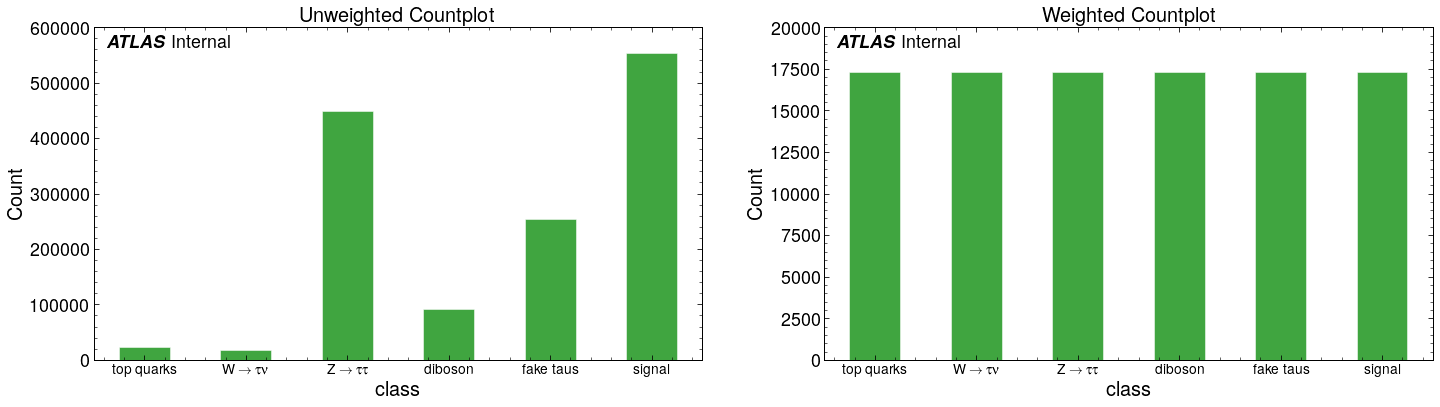

In [20]:
balance_plotter(
    algorithm_type = algorithm_type, 
    df = dataframe['df'], 
    labels = dataframe['labels']
)

In [21]:
dataframe['df']

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n  \
entry                                                              
0          22        True      2      6           0      0     0   
1          11       False      2      3           0      0     0   
2          11        True      2      3           1      0     0   
3           8        True      2      4           2      0     0   
4          13        True      2      3           2      0     0   
...       ...         ...    ...    ...         ...    ...   ...   
1388740    30        True      2      3           0      0     0   
1388741    25        True      2      3           0      0     0   
1388742    23        True      2      3           1      0     0   
1388743    10        True      2      6           0      0     0   
1388744    23        True      2      6           0      0     0   

                 sumMT      sumMTJet   sumMTTauJet  ...  jet_eleMatch_1  \
entry                                               ...                   
0        122664.187500  1.200299e+06  1.322963e+06  ...               0   
1        153499.390625  7.500236e+05  9.035229e+05  ...               0   
2        100656.859375  8.841444e+05  9.848012e+05  ...               0   
3        210207.203125  8.842624e+05  1.094470e+06  ...               0   
4        181634.984375  8.726021e+05  1.054237e+06  ...               0   
...                ...           ...           ...  ...             ...   
1388740  331089.750000  3.314850e+06  3.645940e+06  ...               0   
1388741  167696.937500  1.465636e+06  1.633333e+06  ...               0   
1388742   31196.849609  1.329502e+06  1.360699e+06  ...               0   
1388743  289854.406250  1.523172e+06  1.813026e+06  ...               0   
1388744  232104.375000  1.579506e+06  1.811610e+06  ...               0   

         jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  jet_muMatch_2  \
entry                                                                  
0                   0.0              0              0            0.0   
1                   0.0              0              0            0.0   
2                   0.0              0              0            0.0   
3                   0.0              0              0            0.0   
4                   0.0              0              1            0.0   
...                 ...            ...            ...            ...   
1388740             0.0              0              0            0.0   
1388741             0.0              0              0            0.0   
1388742             0.0              0              0            0.0   
1388743             0.0              0              0            0.0   
1388744             0.0              0              0            0.0   

         jet_timing_0  jet_timing_1  jet_timing_2       selection_name  \
entry                                                                    
0            0.197181     -0.083975      0.038682            topquarks   
1            0.058463      0.964934     -1.163602            topquarks   
2            0.192587     -0.235954      0.362056            topquarks   
3           -0.151218      0.481597     -0.023252            topquarks   
4            0.102353      0.290844     -0.259995            topquarks   
...               ...           ...           ...                  ...   
1388740      0.059946      0.045914     -0.190761  GG_900_870_J85_1tau   
1388741      0.024125     -1.116385     -5.647985  GG_900_870_J85_1tau   
1388742      0.080618     -0.158392     -2.319552  GG_900_870_J85_1tau   
1388743      0.212576      0.655231     -0.116148  GG_900_870_J85_1tau   
1388744      0.023419      0.239091     -0.685700  GG_900_870_J85_1tau   

         class_weight  
entry                  
0            0.736891  
1            0.736891  
2            0.736891  
3            0.736891  
4            0.736891  
...               ...  
1388740      0.031230  
1388741      0.031230  
1388742 

### Shuffle

Shuffling the data to prevent any correlations.

In [22]:
# df = df.sample(frac=1)
# df

### Feature(s) Dropping

Dropping particular features of interest to see how much the correlation and feature importance plots change.

In [23]:
from FeatureDropper import feature_dropper

(1) Dropping the desired feature.

In [24]:
feature_dropper(False)

# feature_drop(True, 'single', 'jet_isBjet_0')
# feature_drop(True, 'single', 'jet_isBjet_1')
# feature_drop(True, 'single', 'jet_isBjet_2')

No dropping performed.


(2) Dropping all features except the desired feature.

In [25]:
feature_dropper(False)

# feature_drop(True, 'all', 'jet_isBjet_0')

No dropping performed.


### Objective & Metric

Defining an objective and a metric.

In [26]:
from ObjectiveDefiner import objective_definer

In [27]:
objective, metric = objective_definer(
    algorithm_type = algorithm_type,
    framework_type = framework_type
)

### Train-Test Split

Splitting the data into train and test subsets. Depending on the type of the algorithm, a label is determined as follows:
* for regression, the $y$-label is set according to the Feature_Regression.py,
* for binary- and multiclass-classification, the $y$-label is set as the "class" feature.

In [28]:
from TrainTestSplitter import train_test_splitter

In [29]:
X, y, X_train, X_test, y_train, y_test = train_test_splitter(
    algorithm_type = algorithm_type, 
    df = dataframe['df'], 
    test_size = 0.3
)

### Selection

In [30]:
X_train_selection_name = X_train['selection_name']
X_test_selection_name = X_test['selection_name']

In [31]:
X.drop(
    'selection_name',
    axis=1, 
    inplace=True
)
X_train.drop(
    'selection_name', 
    axis=1, 
    inplace=True
)
X_test.drop(
    'selection_name',
    axis=1, 
    inplace=True
)

### Weights

There are some difficulties applying negative weights during the training process of a model. Currently, there are 2 known ways to handle this:
* not applying weights at all during the training process,
* applying weights with events that have positive weights only during the training process and evaluating with all weights (events with both positive and negative weights):
    * without normalization,
    * with normalization.

#### Histogram Weights

Extracing weights for histograms.

In [32]:
df_weights = dataframe['df']['weight']
X_train_weights = X_train['weight']
X_test_weights = X_test['weight']

#### Training Weights

Extracing class weights for the training process.

In [33]:
df_class_weights = dataframe['df']['class_weight']
X_class_test_weights = X_test['class_weight']
X_class_train_weights = X_train['class_weight']

#### Negative Weights

Transfering events with negative histogram weights from the train to the test sample.

Defining weights for the training process.

In [34]:
from NegativeWeightApplier import negative_weight_applier

Creating a weight array to be applied during the training process.

In [35]:
apply_negative_weight = False           # True | False
normalize = False                       # True | False

In [36]:
if apply_negative_weight:
    X_train, X_test, y_train, y_test, X_train_weights, X_test_weights = negative_weight_applier(
        apply_negative_weight = apply_negative_weight, 
        normalize = normalize, 
        X_train = X_train, 
        y_train = y_train, 
        X_test = X_test, 
        y_test = y_test
    )
else:
    negative_weight_applier(
        apply_negative_weight = apply_negative_weight
    )

No weight applied.


Dropping the weight features.

In [37]:
X.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)
X_train.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)
X_test.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)

### Normalization

Normalization is not required in decision tree algorithms.

In [38]:
from NormalizationApplier import normalization_applier

In [39]:
normalization_applier(
    framework_type,
    algorithm_type,
)

No normalization performed.


### Preview

Previewing the $ y $- and $ x $-subsets.

In [40]:
X.head()

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n          sumMT  \
entry                                                                           
0        22        True      2      6           0      0     0  122664.187500   
1        11       False      2      3           0      0     0  153499.390625   
2        11        True      2      3           1      0     0  100656.859375   
3         8        True      2      4           2      0     0  210207.203125   
4        13        True      2      3           2      0     0  181634.984375   

           sumMTJet   sumMTTauJet  ...  jet_width_2  jet_eleMatch_0  \
entry                              ...                                
0      1.200299e+06  1.322963e+06  ...     0.036778               0   
1      7.500236e+05  9.035229e+05  ...     0.211321               0   
2      8.841444e+05  9.848012e+05  ...     0.097620               0   
3      8.842624e+05  1.094470e+06  ...     0.178472               0   
4      8.726021e+05  1.054237e+06  ...     0.108371               0   

       jet_eleMatch_1  jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  \
entry                                                                 
0                   0             0.0              0              0   
1                   0             0.0              0              0   
2                   0             0.0              0              0   
3                   0             0.0              0              0   
4                   0             0.0              0              1   

       jet_muMatch_2  jet_timing_0  jet_timing_1  jet_timing_2  
entry                                                           
0                0.0      0.197181     -0.083975      0.038682  
1                0.0      0.058463      0.964934     -1.163602  
2                0.0      0.192587     -0.235954      0.362056  
3                0.0     -0.151218      0.481597     -0.023252  
4                0.0      0.102353      0.290844     -0.259995  

[5 rows x 94 columns]

In [41]:
X_train.head()

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n  \
entry                                                              
681635     19        True      2      3           0      0     0   
1077995    35        True      2      7           2      0     0   
1025203    21       False      2      6           1      0     0   
1200188    21       False      2      5           0      0     1   
1134922    23        True      2      7           1      0     0   

                sumMT    sumMTJet  sumMTTauJet  ...  jet_width_2  \
entry                                           ...                
681635   1.200014e+05  1056194.25  1176195.625  ...     0.136945   
1077995  1.934078e+06  6046037.00  7980115.500  ...     0.036190   
1025203  6.094614e+05  2690165.00  3299626.250  ...     0.055742   
1200188  5.739164e+05   972244.50  1546160.875  ...     0.083971   
1134922  1.419819e+06  3465302.50  4885121.500  ...     0.107002   

         jet_eleMatch_0  jet_eleMatch_1  jet_eleMatch_2  jet_muMatch_0  \
entry                                                                    
681635                0               0             0.0              0   
1077995               0               0             0.0              0   
1025203               0               0             0.0              0   
1200188               0               0             0.0              0   
1134922               0               0             0.0              1   

         jet_muMatch_1  jet_muMatch_2  jet_timing_0  jet_timing_1  \
entry                                                               
681635               0            0.0      0.014755      0.249530   
1077995              0            0.0     -0.094674     -0.067648   
1025203              0            0.0      0.025848     -0.058204   
1200188              0            0.0     -0.136903     -0.020265   
1134922              0            0.0      0.178808      0.039960   

         jet_timing_2  
entry                  
681635       0.367896  
1077995      0.097297  
1025203     -0.125345  
1200188     -0.010864  
1134922      0.028526  

[5 rows x 94 columns]

In [42]:
y.head()

entry
0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

### Correlation

Checking the correlation of the label with the data.

In [43]:
from CorrelationPlotter import correlation_plotter

Plotting the feature correlation scores for the 20 most important features (vertically).

In [46]:
df = dataframe['df']

In [ ]:
correlations = df.corr()[y.name][0 : 20 + 1].sort_values(ascending=False)[
    1:
]

In [ ]:
correlations

METSigSoftTrk    0.239842
METSigPow3       0.211726
met              0.207798
METSig           0.202011
sumMTJet         0.174684
sumMTTauJet      0.174684
mu_n             0.139378
Mtaumu           0.137209
Mt2_taumu        0.136968
Mtauel           0.130334
Mt2_tauel        0.128829
ele_n            0.115684
meff             0.113888
jet_n            0.075423
ht               0.067344
weight           0.040264
nVtx             0.034618
met_phi          0.001499
jet_n_btag      -0.073232
LeptonVeto      -0.192123
Name: class, dtype: float64

In [58]:
feature_corr = df.iloc[:, :20].corr()

In [59]:
feature_corr

nVtx  LeptonVeto     jet_n  jet_n_btag     ele_n      mu_n  \
nVtx           1.000000   -0.006206  0.039687    0.004404 -0.006469  0.012807   
LeptonVeto    -0.006206    1.000000 -0.022289    0.018178 -0.504987 -0.561128   
jet_n          0.039687   -0.022289  1.000000    0.263236  0.003001  0.004484   
jet_n_btag     0.004404    0.018178  0.263236    1.000000 -0.006312 -0.008084   
ele_n         -0.006469   -0.504987  0.003001   -0.006312  1.000000 -0.104380   
mu_n           0.012807   -0.561128  0.004484   -0.008084 -0.104380  1.000000   
sumMTJet      -0.004945   -0.050454  0.612874    0.109348  0.023851  0.005055   
sumMTTauJet   -0.004945   -0.050454  0.612874    0.109348  0.023851  0.005055   
Mt2_taumu      0.004107   -0.272709  0.045527    0.011426 -0.032665  0.481478   
Mt2_tauel     -0.004245   -0.234826  0.050083    0.011577  0.462086 -0.033184   
Mtaumu         0.009545   -0.377224  0.029536   -0.000846 -0.065127  0.661651   
Mtauel        -0.004005   -0.352213  0.027407    0.001234  0.685893 -0.067995   
met           -0.010502    0.007734  0.162734   -0.007804 -0.000428 -0.023071   
met_phi       -0.000538    0.000113 -0.000454    0.000077  0.000458 -0.000369   
METSigSoftTrk -0.051970    0.079381 -0.018666   -0.042535 -0.014827 -0.079156   
METSig        -0.003704    0.161205 -0.172263   -0.076432 -0.081333 -0.103654   
METSigPow3    -0.006656    0.104306 -0.040544   -0.051505 -0.051035 -0.074494   
meff          -0.017655   -0.068652  0.454995    0.057280  0.031445  0.016749   
ht            -0.017577   -0.084317  0.488471    0.070795  0.037597  0.027536   
weight        -0.004524    0.009677  0.029059    0.002073 -0.005654 -0.008254   

               sumMTJet  sumMTTauJet  Mt2_taumu  Mt2_tauel    Mtaumu  \
nVtx          -0.004945    -0.004945   0.004107  -0.004245  0.009545   
LeptonVeto    -0.050454    -0.050454  -0.272709  -0.234826 -0.377224   
jet_n          0.612874     0.612874   0.045527   0.050083  0.029536   
jet_n_btag     0.109348     0.109348   0.011426   0.011577 -0.000846   
ele_n          0.023851     0.023851  -0.032665   0.462086 -0.065127   
mu_n           0.005055     0.005055   0.481478  -0.033184  0.661651   
sumMTJet       1.000000     1.000000   0.092892   0.114914  0.056474   
sumMTTauJet    1.000000     1.000000   0.092892   0.114914  0.056474   
Mt2_taumu      0.092892     0.092892   1.000000   0.022826  0.419909   
Mt2_tauel      0.114914     0.114914   0.022826   1.000000 -0.008509   
Mtaumu         0.056474     0.056474   0.419909  -0.008509  1.000000   
Mtauel         0.074547     0.074547  -0.008460   0.430990 -0.031270   
met            0.793298     0.793298   0.091052   0.113063  0.032463   
met_phi        0.000449     0.000449  -0.000106   0.000723 -0.000018   
METSigSoftTrk  0.505870     0.505870   0.077087   0.113578 -0.040033   
METSig         0.363581     0.363581   0.017169   0.033495 -0.073921   
METSigPow3     0.557978     0.557978   0.047372   0.066728 -0.034067   
meff           0.869244     0.869244   0.090394   0.109957  0.083879   
ht             0.774607     0.774607   0.077740   0.093806  0.089241   
weight         0.005723     0.005723  -0.000843   0.000838 -0.007717   

                 Mtauel       met   met_phi  METSigSoftTrk    METSig  \
nVtx          -0.004005 -0.010502 -0.000538      -0.051970 -0.003704   
LeptonVeto    -0.352213  0.007734  0.000113       0.079381  0.161205   
jet_n          0.027407  0.162734 -0.000454      -0.018666 -0.172263   
jet_n_btag     0.001234 -0.007804  0.000077      -0.042535 -0.076432   
ele_n          0.685893 -0.000428  0.000458      -0.014827 -0.081333   
mu_n          -0.067995 -0.023071 -0.000369      -0.079156 -0.103654   
sumMTJet       0.074547  0.793298  0.000449       0.505870  0.363581   
sumMTTauJet    0.074547  0.793298  0.000449       0.505870  0.363581   
Mt2_taumu     -0.008460  0.091052 -0.000106       0.077087  0.017169   
Mt2_tauel      0.430990  0.113063  0.000723       0.113578  0.033495   
Mtaumu      

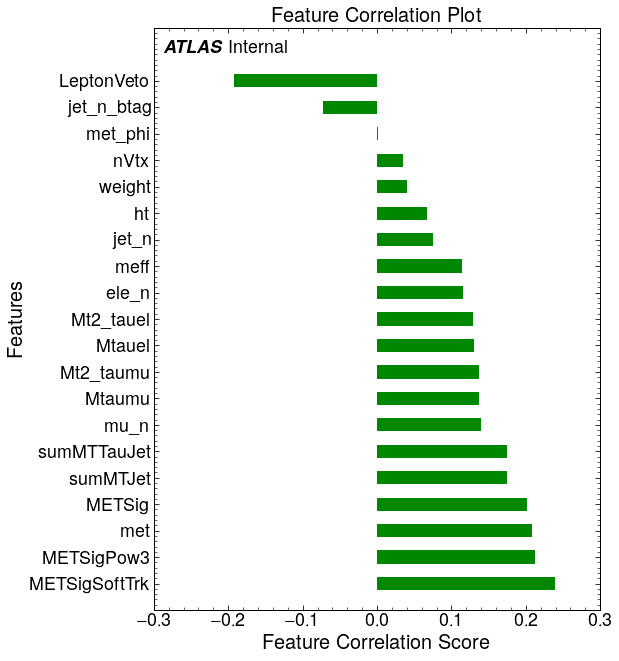

In [43]:
correlation_plotter(
    df = dataframe['df'], 
    y = y, 
    direction = "horizontal", 
    n_features = 20
)

### Parameters

Defining the initial hyperparameter values.

In [47]:
hyperparameters = {
    # ---General Parameters---
    'booster':'gbtree',                     # type of model to run at each iteration
    # # ---General Parameters---

    # # ---Booster Parameters---
    'n_estimators':100000,                   # number of classifiers
    'learning_rate':0.2,                    # the step size at which the optimizer adjusts the model parameters during training
    'max_depth':6,                          # the maximum depth of a tree
    'min_child_weight':1,                   # defines the minimum sum of weights in a child
    'gamma':0,                              # specifies minimum loss reduction to make a split
    'subsample':1.0,                        # defines random fraction of observations for each tree
    'colsample_bytree':1.0,                 # defines random fraction of columns for each tree
    'reg_alpha':0,                          # L1 regularization term on weights
    'reg_lambda':0,                         # L2 regularization term on weights
    # 'scale_pos_weight':1,                 # balance of positive and negative weights (binary)
    'max_delta_step':0,                     # tree’s weight estimation
    # ---Booster Parameters---

    # ---Learning Task Parameters---
    'objective':objective,                  # defines loss function to be minimized
    'tree_method':'gpu_hist',               # tree constructing method. Possibilities: hist, gpu_hist, approx, exact
    'gpu_id':0,                             # selects which GPU card to use (uncheck in case of not using gpu)
    'predictor':'gpu_predictor',
    'seed':1,                               # seed statistic number
    # ---Learning Task Parameters---

    # ---Multiclass Parameters---
    'num_class':len(np.unique(y))           # number of classes (for multiclass-classification only)
    # ---Multiclass Parameters---
}

if algorithm_type != 'multiclass-classification':
    del hyperparameters['num_class']

Defining the fit parameter values.

In [48]:
apply_weight = True

In [49]:
if apply_weight:
    fit_parameters= {
        'X':X_train,
        'y':y_train,
        'sample_weight':X_class_train_weights,
        "eval_set":[(X_train, y_train), (X_test, y_test)],
        'eval_metric':metric,
        'early_stopping_rounds':100,
        'verbose':0
    }
else:
    fit_parameters= {
        'X':X_train,
        'y':y_train,
        "eval_set":[(X_train, y_train), (X_test, y_test)],
        'eval_metric':metric,
        'early_stopping_rounds':100,
        'verbose':0
    }

#### Fitting

Fitting the model with hyper-and fit-parameters.

In [50]:
if algorithm_type == 'regression': 
    xgb_model = xgb.XGBRegressor(**hyperparameters)
elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
    xgb_model = xgb.XGBClassifier(**hyperparameters)
else:
    raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

xgb_model.fit(**fit_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100000,
              n_jobs=0, num_class=6, num_parallel_tree=1,
              objective='multi:softprob', predictor='gpu_predictor',
              random_state=1, ...)

Saving the model.

In [77]:
xgb_model.save_model(f"{path_pickles}/ML/{analysis_base}/{run}/{region}/{channel}_tau/model_xgboost.model")

Loading the model.

In [48]:
# xgb_model = xgb.Booster()
# xgb_model.load_model(f"{path_pickles}/ML/{analysis_base}/{release}/{region}/{channel}_tau/model_xgboost.model")

#### Predicting

Making the predictions and estimating prediction probabilities (the latter only for binary- and multiclass-classification).

In [51]:
predictions = xgb_model.predict(
    X_test, 
    ntree_limit=xgb_model.best_ntree_limit
)

if algorithm_type == 'regression':
    print("Not available for regression.")

elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
    predictions_proba = xgb_model.predict_proba(
        X_test,
        ntree_limit=xgb_model.best_ntree_limit
    )

else:
    raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

#### Loss

Plotting the loss with respect to the number of trees. The optimal tree number is established when there is no improvement in the loss for succeeding, specific number of trees determined in the stopping functionality preventing overfitting.

In [52]:
from LossPlotter import loss_plotter

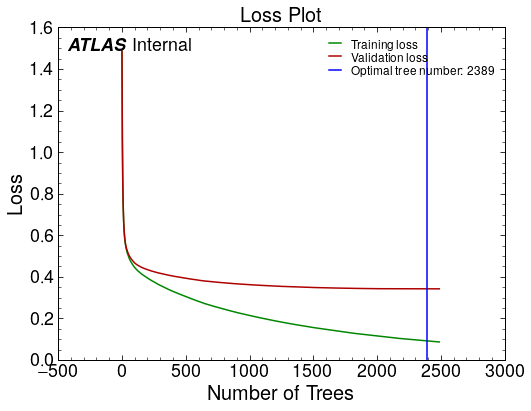

In [53]:
loss_plotter(
    framework_type = framework_type,
    model = xgb_model,
    metric = metric
)

#### Feature Importance

Calculating the feature importance scores using SHAP.

In [54]:
from FeatureImportanceCalculator import feature_importance_calculator

In [55]:
explainer, shap_values, df_feature_importance_scores = feature_importance_calculator(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    model = xgb_model,
    X_train = X_train,
    X_test = X_test,
    columns = X_train.columns,
    events = 10000            # len(X_test) - full
)

In [56]:
df_feature_importance_scores.head(10)

name  mean_abs_shap  stdev_abs_shap
0         nVtx       0.096985        0.101799
1   LeptonVeto       0.194109        0.479266
2        tau_n       0.062394        0.245160
3        jet_n       0.061014        0.085091
4   jet_n_btag       0.389233        0.675711
5        ele_n       0.011848        0.047516
6         mu_n       0.036892        0.213913
7        sumMT       0.395292        0.418949
8     sumMTJet       0.080230        0.093089
9  sumMTTauJet       0.203878        0.304276

Plotting the feature importance scores.
* for the whole spectrum (horizontally and vertically),
* for the 20 most important features (horizontally and vertically),
* for the 20 most important features (horizontally) including dinstinction to individual classes.

In [57]:
from FeatureImportancePlotter import feature_importance_plotter

Plotting the feature importance scores for the whole spectrum (vertically).

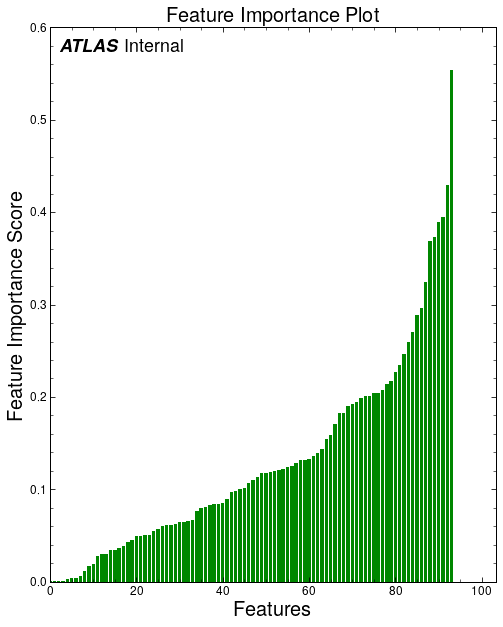

In [58]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train,
    X_test = X_test,

    direction = 'vertical',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = None,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the whole spectrum (horizontally).

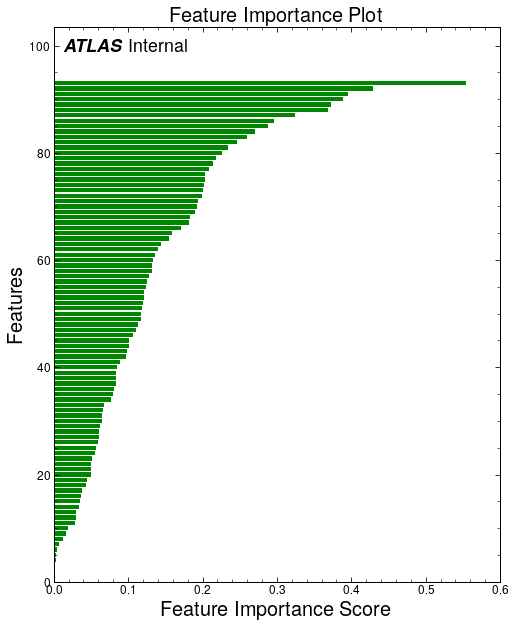

In [59]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train,
    X_test = X_test,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = None,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features (vertically).

In [60]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train,
    X_test = X_test,

    direction = 'vertical',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features (horizontally).

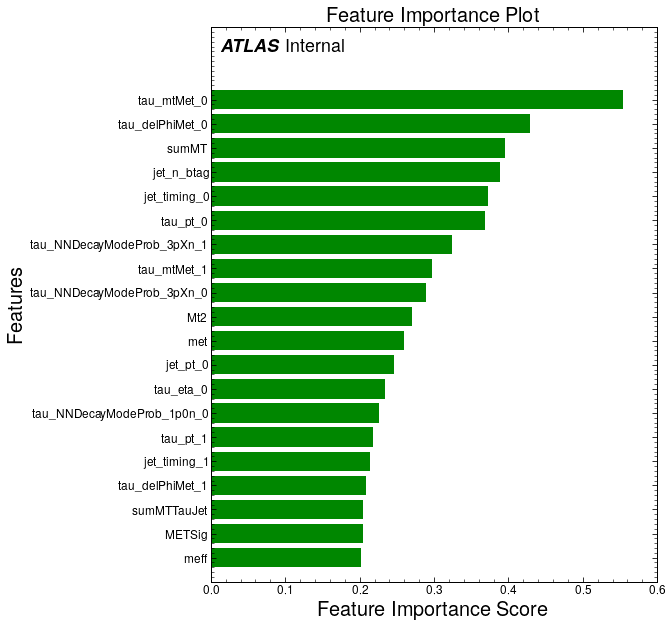

In [61]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train,
    X_test = X_test,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features with distinction of individual classes.

In [62]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train,
    X_test = X_test,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_many',
    shap_values = shap_values,

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

### Evaluation Metrics

#### Output

Composing a dataframe with all relevant results.

In [63]:
from ResultsPresenter import results_presenter

In [64]:
dict_results, df_results = results_presenter(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    y_test = y_test,
    predictions = predictions,
    predictions_proba = predictions_proba
)

Displaying obtained results.

In [65]:
df_results

y_test                      y_probabilities  y_predictions
0            5       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5
1            3   [0.0, 0.03, 0.01, 0.44, 0.5, 0.01]              4
2            2     [0.0, 0.0, 0.93, 0.07, 0.0, 0.0]              2
3            5       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5
4            5       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5
...        ...                                  ...            ...
416619       5       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5
416620       5       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5
416621       1   [0.0, 0.31, 0.17, 0.51, 0.01, 0.0]              3
416622       2  [0.45, 0.25, 0.04, 0.25, 0.02, 0.0]              0
416623       4       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]              4

[416624 rows x 3 columns]

#### Scores

Displaying obtained result scores.

In [66]:
from ScoresPrinter import scores_printer

In [67]:
scores_printer(
    algorithm_type = algorithm_type, 
    y_test = dict_results['y_test'],
    predictions = dict_results['y_predictions'],
)

Precision Score | Accuracy (Micro Average): 88.64%
Precision Score | Macro Average: 68.55%
Precision Score | Weighted Average: 88.73%
Recall Score | Accuracy (Micro Average): 88.64%
Recall Score | Macro Average: 69.96%
Recall Score | Weighted Average: 88.64%
F1 Score | Accuracy (Micro Average): 88.64%
F1 Score | Macro Average: 69.2%
F1 Score | Weighted Average: 88.68%


#### Classification Report

Printing a classification report and a support (for binary- and multiclass-classification). A support is the number of entries each class has.

In [68]:
from ClassificationReportPlotter import classification_report_plotter

In [69]:
classification_report_plotter(
    algorithm_type = algorithm_type, 
    y_test = dict_results['y_test'],
    predictions = dict_results['y_predictions'],
    labels = dataframe['labels']
)

#### Confusion Matrix

Displaying a confusion matrix in terms of recall scoring (for binary- and multiclass-classification).

In [70]:
from ConfusionMatrixPlotter import confusion_matrix_plotter

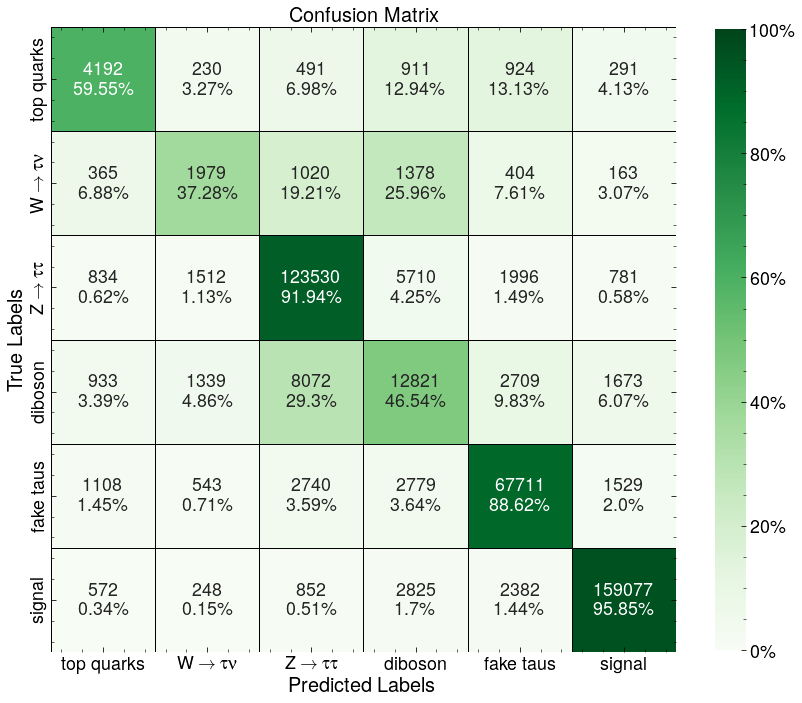

In [71]:
confusion_matrix_plotter(
    algorithm_type = algorithm_type, 
    y_test = df_results['y_test'],
    predictions = dict_results['y_predictions'],
    labels = dataframe['labels']
)

#### ROC & PR Curve

Displaying a Receiver Operating Characteristic and Precision-Recall Curve (for binary- and multiclass-classification).

In [72]:
from CurvePlotter import curve_plotter

<b> Receiver Operating Characteristic Curve. </b>

Automatically calculating ROC AUC (based on the model):

In [73]:
curve_plotter(
    framework_type = framework_type, 
    algorithm_type = algorithm_type, 
    curve_type = 'roc', 
    model = xgb_model, 
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

Manually calculating ROC AUC (based on the predictions):

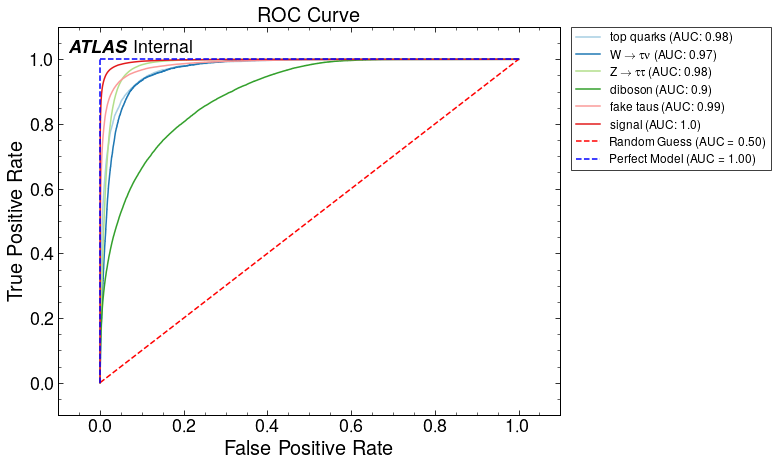

In [74]:
curve_plotter(
    framework_type = framework_type, 
    algorithm_type = algorithm_type, 
    curve_type = 'roc', 
    model = None, 
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

<b> Precision-Recall Curve. </b>

Automatically calculating PR AP (based on the model):

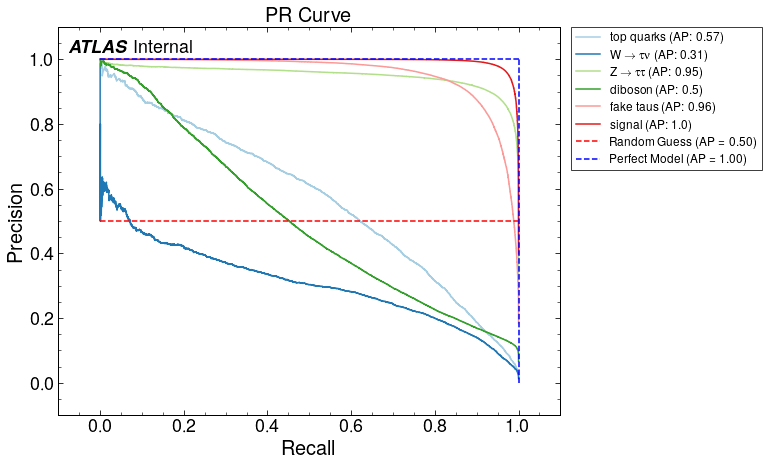

In [75]:
curve_plotter(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    curve_type = 'pr',
    model = xgb_model,
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

Manually calculating PR AP (based on the model):

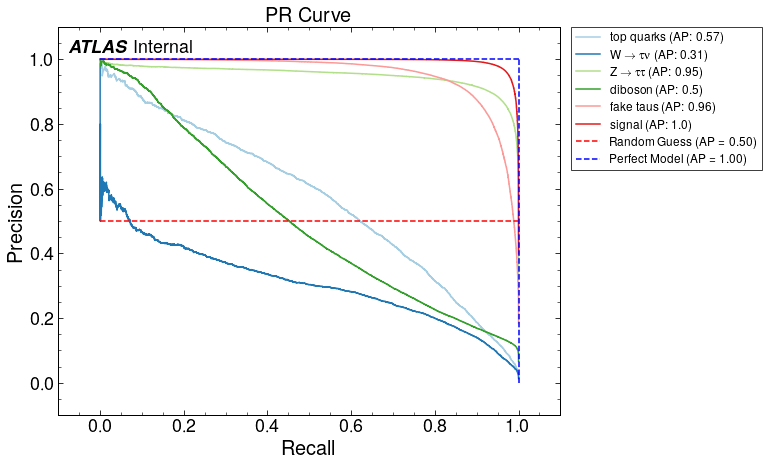

In [76]:
curve_plotter(
    framework_type = framework_type, 
    algorithm_type = algorithm_type, 
    curve_type = 'pr', 
    model = None, 
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

#### Tree Visual

Displaying a tree structure.

In [71]:
from TreePlotter import tree_plotter

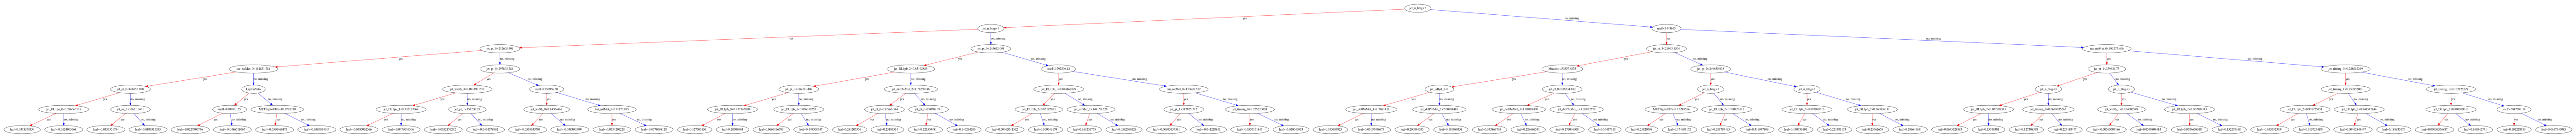

In [72]:
tree_plotter(
    model = xgb_model, 
    nth_tree = 0, 
    width = 100, 
    height = 100
)

Converting raw score into a probability score using logistic function.

In [72]:
from TreePlotter import logistic_converter

In [73]:
logistic_converter(-0.148863658)

0.46285266013413234

## Serialization

Organizing the XGBoost output.

In [78]:
output_xgboost = {
    'meta': dataframe['meta'],
    'region': dataframe['region'],
    'include': dataframe['include'],
    'labels': dataframe['labels'],
    'ML-info': {
        'framework_type': framework_type,
        'algorithm_type': algorithm_type,
        'objective': objective,
        'metric': metric
    },
    'output': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_selection_name': X_train_selection_name,
        'X_test_selection_name': X_test_selection_name,
        'X_test_weights': X_test_weights,
        'X_train_weights': X_train_weights,
        'X_class_test_weights': X_class_test_weights,
        'X_class_train_weights': X_class_train_weights,
        'dict_results': dict_results,
        'df_results': df_results
    },
}

Serializing the XGBoost output.

In [79]:
with open(f"{path_pickles}/ML/{analysis_base}/{run}/{region}/{channel}_tau/output_xgboost.pkl", "wb") as file:
    pickle.dump(output_xgboost, file)